In [1]:
# Sentiment Analysis using spaCy, TF-IDF, and Logistic Regression

# Import Libraries
import pandas as pd
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load Dataset
df = pd.read_csv("sentiment_analysis_dataset.csv", on_bad_lines='warn')

# Display dataset info
print("Dataset Preview:")
display(df.head())
print("\nDataset Info:")
print(df.info())

# Rename for consistency
df.columns = ['Comment', 'Sentiment']

Dataset Preview:


,Comment,Sentiment
0,Achieving million views in days is dangerous,Positive
1,How many people here want to participate in su...,Neutral
2,Mrbeast is slowly turning into mrjigsaw,Negative
3,genuinely can't believe how dystopian this is,Negative
4,Have of the worlds smartest people compete in ...,Neutral



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7826 entries, 0 to 7825
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    7822 non-null   object
 1   Sentiment  7826 non-null   object
dtypes: object(2)
memory usage: 122.4+ KB
None


In [3]:
df['Sentiment'].value_counts()

,count
Sentiment,
Positive,4690
Neutral,2036
Negative,1099
Neutral,1


In [4]:
# Initialize spaCy Model
nlp = spacy.load("en_core_web_sm")

In [5]:
# Preprocessing Function
def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and token.text != "not"
    ]
    return " ".join(tokens)

print("Preprocessing sample...")
df['cleaned_text'] = df['Comment'].astype(str).apply(preprocess_text)

print("\nSample cleaned text:")
print(df[['Comment', 'cleaned_text']].head())

Preprocessing sample...

Sample cleaned text:
                                             Comment  \
0       Achieving million views in days is dangerous   
1  How many people here want to participate in su...   
2            Mrbeast is slowly turning into mrjigsaw   
3      genuinely can't believe how dystopian this is   
4  Have of the worlds smartest people compete in ...   

                                        cleaned_text  
0                 achieve million view day dangerous  
1                people want participate challenge ?  
2                       mrbeast slowly turn mrjigsaw  
3                        genuinely believe dystopian  
4  world smart people compete series intellectual...  


In [6]:
# TF-IDF Vectorization
# Filter out sentiment classes with only one member before vectorization and splitting
sentiment_counts = df['Sentiment'].value_counts()
minority_classes = sentiment_counts[sentiment_counts < 2].index
df_filtered = df[~df['Sentiment'].isin(minority_classes)].copy()

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
X = tfidf.fit_transform(df_filtered['cleaned_text'])
y = df_filtered['Sentiment']

In [7]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Model Training
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)


Accuracy: 0.9840255591054313

Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.99      0.99       233
     Neutral       0.95      0.98      0.97       384
    Positive       0.99      0.98      0.99       948

    accuracy                           0.98      1565
   macro avg       0.98      0.98      0.98      1565
weighted avg       0.98      0.98      0.98      1565



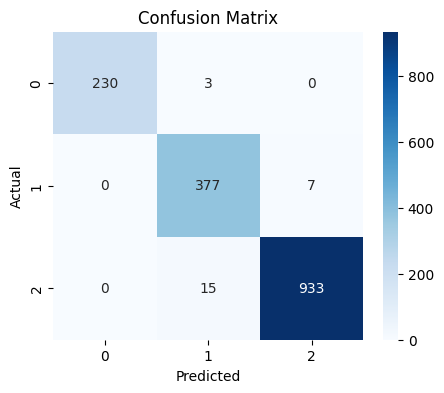

In [9]:
# Evaluation
y_pred = model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [10]:
# Predict Sentiment for New Comments
def predict_sentiment(new_text):
    # Step 1: preprocess
    cleaned = preprocess_text(new_text)

    # Step 2: TF-IDF transform
    vector = tfidf.transform([cleaned])

    # Step 3: model prediction
    prediction = model.predict(vector)[0]

    return prediction

# Example predictions
print(predict_sentiment("I love this video so much!"))
print(predict_sentiment("This is the worst thing ever."))
print(predict_sentiment("It's okay, nothing special."))


Positive
Negative
Neutral



Top Positive Features (words that push TOWARD the Positive class):
['cry' 'nice' 'great' 'proud' 'amazing' 'coach' 'congratulation' 'love'
 'happy' 'congrat']

Top Negative Features (words that push AWAY from the Negative class):
['love' 'challenge' 'nolan' 'day' 'crazy' 'thank' 'happy' 'get' 'coach'
 'million']


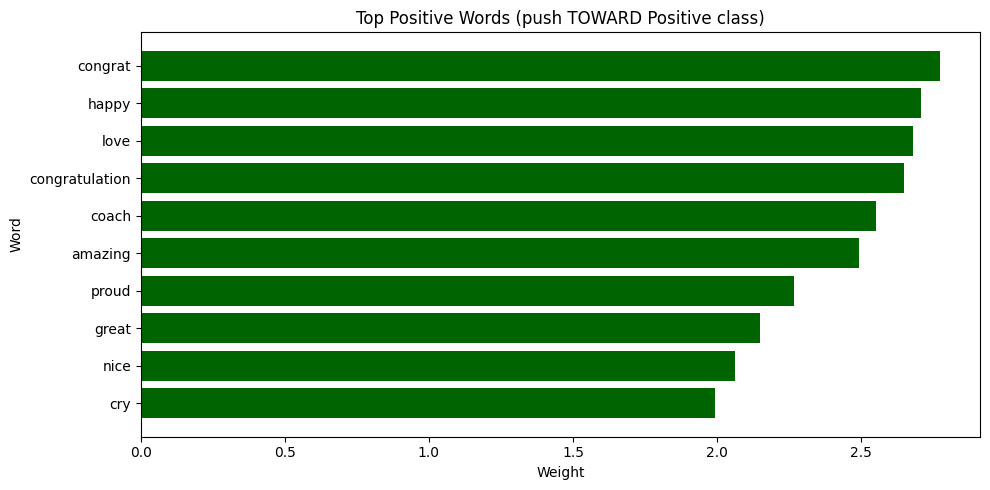

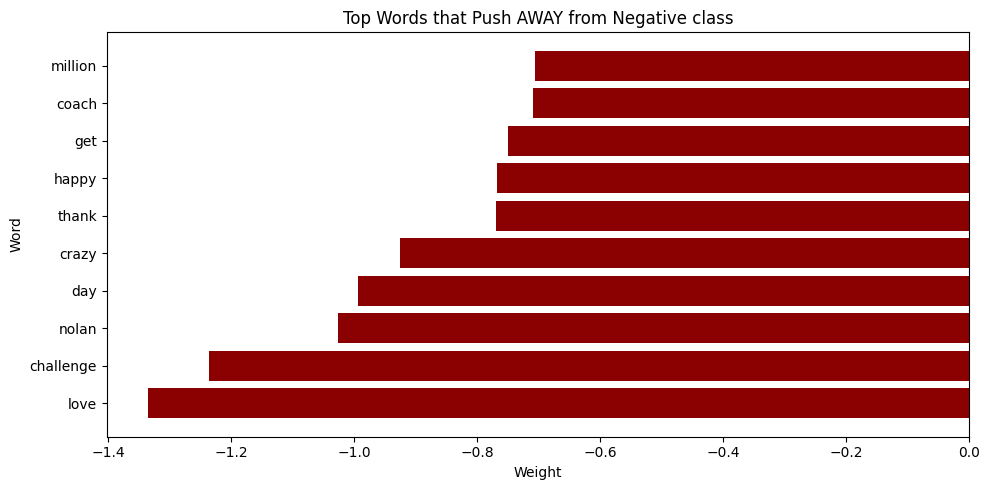

In [13]:
# Get feature names and class list
feature_names = np.array(tfidf.get_feature_names_out())
classes = list(model.classes_)

# Identify the coefficient row for each class
pos_idx = classes.index("Positive")
neg_idx = classes.index("Negative")

pos_coef = model.coef_[pos_idx]       # weights for Positive class
neg_coef = model.coef_[neg_idx]       # weights for Negative class

# Sort coefficients
pos_sorted_idx = pos_coef.argsort()
neg_sorted_idx = neg_coef.argsort()

top_n = 10

print("\nTop Positive Features (words that push TOWARD the Positive class):")
print(feature_names[pos_sorted_idx[-top_n:]])

print("\nTop Negative Features (words that push AWAY from the Negative class):")
print(feature_names[neg_sorted_idx[:top_n]])


# Plot positive features
pos_sorted_idx = np.argsort(pos_coef)
pos_top_idx = pos_sorted_idx[-top_n:]
pos_words = feature_names[pos_top_idx]
pos_weights = pos_coef[pos_top_idx]

plt.figure(figsize=(10, 5))
plt.barh(pos_words, pos_weights, color="darkgreen")
plt.xlabel("Weight")
plt.ylabel("Word")
plt.title("Top Positive Words (push TOWARD Positive class)")
plt.tight_layout()
plt.show()


# Plot negative features
neg_sorted_idx = np.argsort(neg_coef)
neg_top_idx = neg_sorted_idx[:top_n]
neg_words = feature_names[neg_top_idx]
neg_weights = neg_coef[neg_top_idx]

plt.figure(figsize=(10, 5))
plt.barh(neg_words, neg_weights, color="darkred")
plt.xlabel("Weight")
plt.ylabel("Word")
plt.title("Top Words that Push AWAY from Negative class")
plt.tight_layout()
plt.show()
